# Quantitative Analysis

## Objective
The goal of this analysis is to evaluate a baseket of U.S. auto-related equities, TSLA versus its competitors in a portfolio
- Tickers are:
Tesla TSLA, Amazon AMZN, Ford F, Rivian RIVN.
TSLA 
Using:
- Historical return and covariance estimation
- ~ 1,000-day Monte Carlo portfolio simulation
- Value-at-Risk (VaR) and Conditional VaR (CVaR) 
- A 3-year forward option valuation for TSLA
- A Monte-Carlo convergence examination

### Simulate price paths of stock portfolio

In [239]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as si
from scipy.stats import norm
import matplotlib.pyplot as plt

In [148]:
# import data
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change().dropna()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

In [149]:
#  TSLA, Rivian, Ford, Amazon
tickers = ['TSLA', 'RIVN', 'F', 'AMZN']

In [150]:
# time window 2012 - 2025; 4 years
startDate = dt.datetime(2021,11,9)
endDate = dt.datetime(2025,11,23)

In [151]:
date_difference = endDate - startDate
years = date_difference.days // 365
days = date_difference.days % 365
years, days

(4, 15)

In [152]:
returns, meanReturns, covMatrix = get_data(tickers, startDate, endDate)
print(f"Mean Returns:\n{meanReturns}\n")
print(f"Covariance Matrix:\n{covMatrix}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19536\3769590260.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stockData = yf.download(stocks, start=start, end=end)
[*********************100%***********************]  4 of 4 completed

Mean Returns:
Ticker
AMZN    0.000511
F       0.000177
RIVN   -0.000672
TSLA    0.000860
dtype: float64

Covariance Matrix:
Ticker      AMZN         F      RIVN      TSLA
Ticker                                        
AMZN    0.000554  0.000200  0.000432  0.000433
F       0.000200  0.000617  0.000454  0.000355
RIVN    0.000432  0.000454  0.002443  0.000892
TSLA    0.000433  0.000355  0.000892  0.001544


Based on mean daily returns:
- TSLA shows the highest mean retun, consistent with its high volatility and growth profile
- AMZN is stable, low covariance, stabilizing the portfolio
- F has low return, moderate risk
- RIVN high risk, high reward (strongest competitor to TSLA EVs)

### Monte Carlo Simulation

Observations from the Chart:
- High dispersion across simulated paths.
- Some paths reach $400K+, showing fat-tail upside driven by TSLA volatility.
- Lower paths indicate potential for significant drawdowns.

Implication:
A portfolio containing TSLA and RIVN carries large right-tail opportunity but also elevated downside risk.

In [153]:
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

In [154]:
mc_sims = 10000 #sample
T = 1008 # T = 252 trading days/year x 4 = 1008

In [155]:
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

In [156]:
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

In [157]:
initialPortfolio = 10000

In [158]:
np.random.seed(0)

In [159]:
for m in range(0, mc_sims):
    # generate uncorrelated random variables Z for dauly returns
    Z = np.random.normal(size=(T, len(weights)))
    
    # get the correlation structure by Cholesky decomposition
    L = np.linalg.cholesky(covMatrix) # covariance matrix

    # calculate correlated daily returns
    dailyReturns = meanM + np.inner(L,Z) # combine mean and covariance for correleated returns

    # simulate portfolio 
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

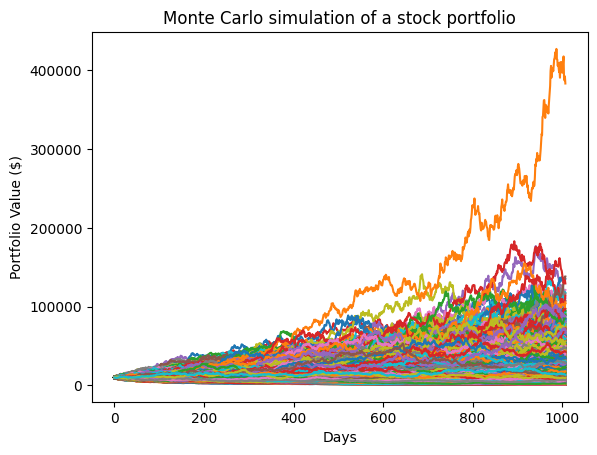

In [160]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo simulation of a stock portfolio')
plt.show()

#### Assess downside risk

In [161]:
# calculating VaR
# For alpha=5, representing the worst 5% of potential outcomes
def mcVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

In [162]:
def mcCVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [163]:
portResults = pd.Series(portfolio_sims[-1,:])

In [164]:
VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

In [166]:
print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))
# Risk Metrics 
# VaR (value at risk) indicates that 95% of the time, portfolio won't lose more than $7102.27 within 1008 days. The 5% worst-case scenarios result in losses greater than this amount
# CVar (conditional value at risk) tells that in the worst 5% of outcomes, the average loss is likely to be $7887.68, indicating that the tail risk is more severe than the loss represented by the VaR

VaR_5 $7102.27
CVaR_5 $7887.68


## Valuation by Simulation

#### Step 1 fetch TSLA option chain and market data
Extract:  
- implied volatility (IV)
- bid/ask mid price
- spot price
- time to expiry T

In [225]:
def get_tsla_option_data(strike, target_years=3):
    tsla = yf.Ticker("TSLA")

    today = dt.date.today()
    target_date = today + dt.timedelta(days=target_years * 365)

    # List all expiration dates
    expiries = tsla.options
    expiries_dt = [dt.datetime.strptime(e, "%Y-%m-%d").date() for e in expiries]

    # Find the expiration closest to 3 years from today
    best_expiry = min(expiries_dt, key=lambda d: abs(d - target_date))
    best_expiry_str = best_expiry.strftime("%Y-%m-%d")

    print(f"The nearest expiry to 3 years is: {best_expiry_str}")

    # Load option chain data
    chain = tsla.option_chain(best_expiry_str)
    calls = chain.calls

    # Select row with given strike
    call = calls[calls["strike"] == strike]
    if call.empty:
        raise ValueError(f"Strike {strike} not available for expiry {best_expiry_str}")

    # Extract implied volatility and market mid price
    iv = float(call["impliedVolatility"].iloc[0])
    market_price = float((call["bid"].iloc[0] + call["ask"].iloc[0]) / 2)

    # Current TSLA spot price
    spot = float(yf.download("TSLA", period="1d")["Close"].iloc[-1])

    # Time to expiration
    T = (best_expiry - today).days / 365

    return spot, iv, market_price, T, best_expiry_str

#### Closed-Form Solution: Black–Scholes Call Price
- compute the fair value of a European call option
- **d1** measures how many sd TSLA stock is above strike
- **d2** is the probavility-adjusted version of d1 (used for the chance the option finishes in the money)

In [257]:
# Black–Scholes Pricing Function
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    C = S * si.norm.cdf(d1) - K * np.exp(-r*T) * si.norm.cdf(d2)
    return C

### Greeks Calculation (Black–Scholes Sensitivities)

This greeks function computes the five primary Greeks for a European call option:
- **Delta**: sensitivity to stock price
- **Gamma**: sensitivity of delta (curvature)
- **Vega**: sensitivity to volatility
- **Theta**: sensitivity to time decay
- **Rho**: sensitivity to interest rates

Greeks help quantify risk and are essential for hedging and risk management.

In [227]:
def greeks(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    delta = si.norm.cdf(d1)
    gamma = si.norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * si.norm.pdf(d1) * np.sqrt(T)
    theta = -(S * si.norm.pdf(d1) * sigma) / (2*np.sqrt(T)) - r*K*np.exp(-r*T)*si.norm.cdf(d2)
    rho = K * T * np.exp(-r*T) * si.norm.cdf(d2)

    return delta, gamma, vega, theta, rho

### Monte Carlo Simulation for European Call Option (Geometric Brownian Motion)

monte_carlo_call function prices a European call option using a multi-step Monte Carlo simulation.
It models the stock price under the risk-neutral measure using Geometric Brownian
Motion (GBM), simulates many possible future price paths, computes option payoffs at 
maturity, discounts them to the present, and returns:

- Monte Carlo estimated price
- Standard error of the estimator

Monte Carlo allows flexible, simulation-based pricing and approximates Black–Scholes 
when the number of simulations is large (which is 10000).

In [228]:
def monte_carlo_call(S, K, T, r, sigma, M=10000, N=252*3):
    dt = T / N
    nudt = (r - 0.5*sigma**2) * dt
    volsdt = sigma * np.sqrt(dt)

    lnS = np.log(S)
    Z = np.random.normal(size=(N, M))
    lnSt = lnS + np.cumsum(nudt + volsdt * Z, axis=0)
    ST = np.exp(lnSt[-1])

    payoff = np.maximum(ST - K, 0)
    price = np.exp(-r*T) * np.mean(payoff)
    se = np.std(payoff, ddof=1) / np.sqrt(M)

    return price, se

### Main engine for TSLA Option Pricing Engine in 3-year horizon
- **Market data** (TSLA spot, option chain, implied volatility, expiry)
- **Black–Scholes model** (closed-form call price and Greeks)
- **Monte Carlo simulation** (path-based pricing under GBM)
- **Market comparison** (model price vs. actual option mid price)

In [232]:
def tsla_option_engine(strike, r=0.035):

    S, sigma, market_price, T, expiry = get_tsla_option_data(strike)

    print("\n=== TSLA OPTION ENGINE (3-YEAR FORWARD) ===")
    print(f"Spot Price (S):       {S:.2f}")
    print(f"Strike (K):           {strike}")
    print(f"Expiry:               {expiry}")
    print(f"Time to Expiry (T):   {T:.4f} years")
    print(f"Implied Volatility:   {sigma:.4f}")
    print(f"Market Price:         {market_price:.2f}")
    print("------------------------------------------")

    # Black–Scholes
    bs_price = black_scholes_call(S, strike, T, r, sigma)
    delta, gamma, vega, theta, rho = greeks(S, strike, T, r, sigma)

    print(f"Black-Scholes Price:  {bs_price:.2f}")
    print(f"Delta: {delta:.4f},  Gamma: {gamma:.6f},  Vega: {vega:.2f},")
    print(f"Theta: {theta:.2f},  Rho: {rho:.2f}")

    # Monte Carlo
    mc_price, mc_se = monte_carlo_call(S, strike, T, r, sigma)

    print("------------------------------------------")
    print(f"Monte Carlo Price:    {mc_price:.2f}  (SE ± {mc_se:.2f})")

    diff = mc_price - market_price
    print("------------------------------------------")
    print(f"Difference vs Market: {diff:.2f}")

    if diff > 0:
        print("→ Option is OVERPRICED by the market (SELL / SHORT)")
    else:
        print("→ Option is UNDERPRICED by the market (BUY / LONG)")
    return mc_price, mc_se, market_price

In [251]:
#  call the tsla_option_engine funcetion
# strike OTM out of the money 420
mc_price, mc_se, market_price = tsla_option_engine(strike=420)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19536\4497915.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spot = float(yf.download("TSLA", period="1d")["Close"].iloc[-1])
[*********************100%***********************]  1 of 1 completed

The nearest expiry to 3 years is: 2028-01-21

=== TSLA OPTION ENGINE (3-YEAR FORWARD) ===
Spot Price (S):       391.09
Strike (K):           420
Expiry:               2028-01-21
Time to Expiry (T):   2.1616 years
Implied Volatility:   0.6419
Market Price:         133.18
------------------------------------------
Black-Scholes Price:  142.51
Delta: 0.6831,  Gamma: 0.000965,  Vega: 204.77,
Theta: -34.77,  Rho: 269.47



C:\Users\ASUS\AppData\Local\Temp\ipykernel_19536\4497915.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spot = float(yf.download("TSLA", period="1d")["Close"].iloc[-1])


------------------------------------------
Monte Carlo Price:    142.84  (SE ± 4.80)
------------------------------------------
Difference vs Market: 9.66
→ Option is OVERPRICED by the market (SELL / SHORT)


Interpretation:
- The model fair value ~ $142.84
- Market price: $133.18
Because the model price is higher than the market price, meaning the market is selling this option too cheaply.
- Meaning TSLA 420 is underpriced, implying a **buy opportunity, long-term investment** due to market mispricing opportunity

### Convergence plot

This plot illustrates the uncertainty around the Monte Carlo price estimate
Monte Carlo gives an approximate fair value using random simulations, so the estimate has noise measured by the standard error (SE)

In [252]:
C0 = mc_price
SE = mc_se

In [253]:
x1 = np.linspace(C0 - 3*SE, C0 - 1*SE, 100)
x2 = np.linspace(C0 - 1*SE, C0 + 1*SE, 100)
x3 = np.linspace(C0 + 1*SE, C0 + 3*SE, 100)

In [254]:
s1 = norm.pdf(x1, C0, SE)
s2 = norm.pdf(x2, C0, SE)
s3 = norm.pdf(x3, C0, SE)

In [255]:
plt.figure(figsize=(10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

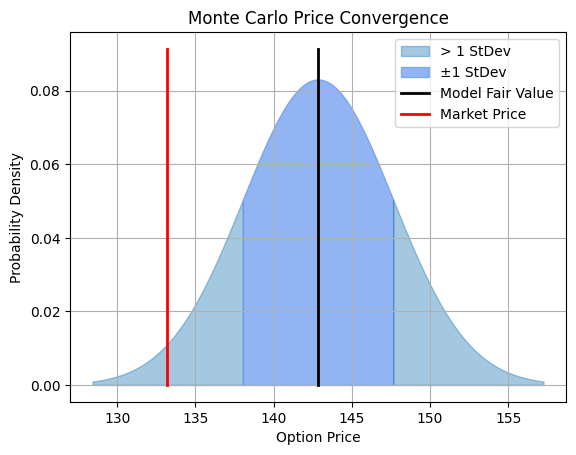

In [256]:
plt.fill_between(x1, s1, color='tab:blue', alpha=0.4, label='> 1 StDev')
plt.fill_between(x2, s2, color='cornflowerblue', alpha=0.7, label='±1 StDev')
plt.fill_between(x3, s3, color='tab:blue', alpha=0.4)

plt.plot([C0, C0], [0, max(s2)*1.1], 'k', linewidth=2, label='Model Fair Value')
plt.plot([market_price, market_price], [0, max(s2)*1.1], 'r', linewidth=2, label='Market Price')

plt.ylabel("Probability Density")
plt.xlabel("Option Price")
plt.title("Monte Carlo Price Convergence")
plt.legend()
plt.grid(True)
plt.show()

Overview, convergence plot shows:
- A normal distribution centered at the MC price 142.84
- ±1 SE range highlighted
- Market price (red) is far left of ±1 SE

Conclusion from the plot:
- The probability that the true fair value is as low as the market price is very small.
- Thus, statistically, the **TSLA 420C is cheap relative to model expectations**.

Possible Insights based on the model:
- Buy TSLA or long TSA call options
- Allocating a portion of 2,000 or 3,000 to AMZN for stabiity if one wishes to diversify portfolio
- Might limit exposure to RIVN and F unless hedging for market or sector risks